In [1]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot, Scatterplot
from decimal import Decimal
from operator import add,sub
from scipy.optimize import LinearConstraint, BFGS, Bounds
import scipy as sp


In [2]:

ts_var=h5py.File('/media/zahra/DATA/ex_3by3_dish_var_scatter_pt01/draco_synthesis_nofluc/maps/tstream_2.h5','r')
ag_var=h5py.File('/media/zahra/DATA/ex_3by3_dish_var_scatter_pt01/draco_synthesis_nofluc/rand_gains/sig_no_fluc/app_gain_2.h5','r')
rg_var=h5py.File('/media/zahra/DATA/ex_3by3_dish_var_scatter_pt01/draco_synthesis_nofluc/rand_gains/sig_no_fluc2.h5','r')

gn_var=h5py.File('/media/zahra/DATA/ex_3by3_dish_var_scatter_pt01/draco_synthesis_nofluc/rand_gains/ts_final/app_gain_noise_2.h5','r')


In [3]:
m=manager.ProductManager.from_config('/media/zahra/DATA/ex_3by3_dish_var_scatter_pt01/prod_params_custom.yaml')

#m_orig = manager.ProductManager.from_config('/home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/prod_params_custom.yaml')

#correlation_arr,sum_counts,corr_counts=Bls_counts(m_orig)

#ant1_org=correlation_arr[:,0].astype(int)
#ant2_org=correlation_arr[:,1].astype(int)

#Scatterplot(m)
Ndish=9
t=m.telescope
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]

print x

Product directory: /media/zahra/DATA/ex_3by3_dish_var_scatter_pt01/bt_matrices
[1.31089497e-02 9.42568310e-03 1.58701478e-02 6.00298620e+00
 5.98536794e+00 6.00564054e+00 1.19866214e+01 1.19968662e+01
 1.19874999e+01 1.31089497e-02 9.42568310e-03 1.58701478e-02
 6.00298620e+00 5.98536794e+00 6.00564054e+00 1.19866214e+01
 1.19968662e+01 1.19874999e+01]


In [4]:
xx,yy=np.meshgrid(x[:Ndish],y[:Ndish])
antvec=np.arange(x[:Ndish].size)
ant1_uv,ant2_uv=np.meshgrid(antvec,antvec)
umat=xx*2-((xx)*2).transpose()
print umat.shape
vmat=yy*2-((yy)*2).transpose()
isok=np.where(ant2_uv>ant1_uv)
ant1_org_uv=ant1_uv[isok]
ant2_org_uv=ant2_uv[isok]
u_org=umat[isok]
print u_org.shape
v_org=vmat[isok]

(9, 9)
(36,)


In [5]:
time_channel=400
Ndish=9
Nbls=9*8/2
random_pt1=np.load('random_pt1.npy')
run=1

v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
vecs=1.e3*np.vstack([v1,v2])
src=np.zeros(2*Nbls)
arr=Visibilities_grid(m,ts_var,rg_var,ag_var, gn_var,time_channel,50,1)
vis_org=arr[2][:,time_channel]
sigma=arr[-1]
noise_org=sigma**2*np.ones(2*Nbls)

print vis_org.shape, u_org.shape

(0.012207031977595827, 'sigma_gn')
(36,) (36,)


In [54]:
vis,u,v,noise,ant1,ant2,edges,_,_=corrcal2.grid_data(vis_org,u_org,v_org,noise_org,ant1_org_uv,ant2_org_uv, tol=0.01)
print edges.shape

(37,)


In [7]:

big_noise=np.zeros(2*noise.size)
big_noise[0::2]=noise
big_noise[1::2]=noise

big_vis=np.zeros(2*vis.size)
big_vis[0::2]=np.real(vis)
big_vis[1::2]=np.imag(vis)

mat=corrcal2.sparse_2level(big_noise,vecs,src,2*edges) #init

gain=rg_var['gain'][0,:Ndish,time_channel]
sim_gains=np.append(gain.real,gain.imag)
sim_gains=np.zeros(Ndish*2)
sim_gains[0::2]=gain.real
sim_gains[1::2]=gain.imag
sim_gains_amp=sim_gains[0::2]
sim_gains_phase=sim_gains[1::2]

mult=random_pt1+1.
gvec=np.array([])
for i in range(len(sim_gains)):
    gvec=np.append(gvec,sim_gains[i]+random_pt1[i])
    #gvec=np.append(gvec,sim_gains[i]*mult[i])

fac=1.;
normfac=1.
asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(big_vis,mat,ant1,ant2,fac,normfac))
#asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
fit_gains_run=asdf/fac

rec_gains_amp=fit_gains_run[0::2]

print rec_gains_amp

         Current function value: 0.005926
         Iterations: 1
         Function evaluations: 75
         Gradient evaluations: 61
[1.07606107 0.93874414 0.89563328 1.24816236 0.87842354 0.93795812
 0.88412548 0.94902632 1.11615165]


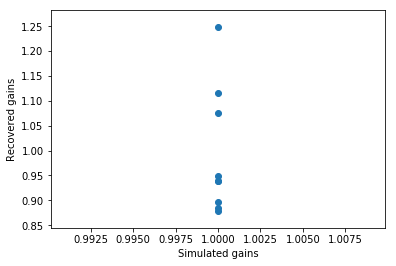

In [8]:
fig, ax = plt.subplots()

lims = [0.5,  # min of both axes
    np.max([ax.get_xlim()]),  # max of both axes
]
ax.scatter(sim_gains_amp, rec_gains_amp)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.9,1.025)
#plt.xlim(0.9,1.1)